
Author: Eunsuh Kim (POSTECH), Minseok Choi (POSTECH)

Contact : s2077@postech.ac.kr


# Hands-on tutorial on SIR using PINN

The tutorial is based on pytorch, an end-to-end platform for machine learning.

Please use **Google Colab** [here](https://colab.research.google.com/?utm_source=scs-index) if you don't have python and/or pytorch installed on your local machine. (Read "colab_how_to_start.pdf" if you do not know how to start Colab.)

To highlight different implementation aspects, let us now consider to train PINN for SIR problem (ODE).

All elements defining our neural network implementation can be summarized in the following pytorch class. Here we assume that the reader is familiar with the basic pytorch structure and semantics. For a primer on pytorch please consider the series of tutorials presented [here](https://pytorch.org/tutorials/).

In [6]:
import numpy as np
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import grad

# Set device : "cuda" or "cpu"
device = torch.device("cuda")

# Fix the random seed for reproducibility
torch.manual_seed(2021)
np.random.seed(2021)

# For reference solution
from scipy.integrate import odeint

# SIR problem

Consider the following SIR problem:

$$\frac{dS}{dt}=-\beta \frac{SI}{N}, \quad t \in [0,20] $$
$$\frac{dI}{dt}=\beta \frac{SI}{N}-\gamma I $$
$$\frac{dR}{dt}=\gamma I $$
with $S(0)=99,I(0)=1,R(0)=0$ and 
where $S(t)$, $I(t)$ and $R(t)$ denote the population of the Suspective, Infected, and Recovered, respectively.

In [7]:
# Compute residual for SIR
def SIR(net,t,params):
    N, beta, gamma = params
    u = net.forward(t)
    S = u[:,0:1]
    I = u[:,1:2]
    R = u[:,2:3]
    S_t = grad(S.sum(), t, create_graph=True)[0]
    I_t = grad(I.sum(), t, create_graph=True)[0]
    R_t = grad(R.sum(), t, create_graph=True)[0]
    u_t = torch.cat([S_t,I_t,R_t],dim=1)
    loss_f = u_t + torch.cat([beta*S*I/N,-beta*S*I/N+gamma*I,-gamma*I],dim=1)
    loss_f = torch.mean(torch.square(loss_f))
    return loss_f

# ODE parameters
N = 100        # population
beta = 1.0     # infected person infects 1 other person per day
D = 4.0        # infections lasts D days
gamma = 1.0 / D
SIR.params = [N, beta, gamma]

# Initial condition
S0 = 99
I0 = 1
R0 = 0

# time domain
tl = 0 
tr = 20

# Making test and training samples
In the following cell, we set 
- the number of collocation points $N_{colloc}$
- collocation and initial points $X_{colloc}$, $X_{ic}$, $U_{ic}$
- test data (for validation of model) $X_{test}$, $U_{test}$

In [8]:
# Make test data

def deriv(u, t, N, beta, gamma):
    S, I, R = u
    dSdt = -beta * S * I / N # 각 시점에서의 변화량
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Grid of time points (in days)
t = np.linspace(tl, tr, 501)

# Initial conditions vector 
u0 = S0, I0, R0 # 초기 값

# Integrate the SIR equations over the time
u = odeint(deriv, u0, t, args=(N, beta, gamma))

# Make test tensors
X_test = torch.tensor(t,dtype=torch.float64,device=device).view(-1,1) # 시간에 대한 방정식이므로
U_test = torch.tensor(u,dtype=torch.float64,device=device).view(-1,3) # S, I, R 3가지 상태가 존재하기 때문에

# Set the number of collocation points
N_colloc = 2000 # collocation points에서도 편미분 방정식을 만족시켜야 한다 -> 초기 조건과 경계 조건에서도 만족해야 함

# Collocation points
X_colloc = torch.rand(N_colloc,dtype=torch.float64,device=device).view(-1,1)*(tr-tl)+tl
X_colloc.requires_grad_()

# For input normalization
X_mean = torch.mean(X_colloc,0).detach() # detach() : 값이 변하지 않음
X_std = torch.std(X_colloc,0).detach() 

# Initial training points
X_ic = torch.tensor([0],dtype=torch.float64,device=device).view(-1,1)
U_ic = torch.tensor([S0,I0,R0],dtype=torch.float64,device=device).view(-1,3)

# For output normalization
U_mean = torch.mean(U_ic)
U_std = torch.std(U_ic)

# Calculate relative L2 error
def calculate_relative_err(net):
    U_pred = net.predict(X_test)
    err = torch.abs(U_pred-U_test)
    err = torch.linalg.norm(err)/torch.linalg.norm(U_test)        
    return err.item()

AssertionError: Torch not compiled with CUDA enabled

# PINN class definition

In [7]:
# PINN class for BVP and LotkaVolterra
class PINN(nn.Module):   
    def __init__(self,
                governing_eqn = None,
                Fourier_embedding = True,
                layers = [50,50,50,50],
                X_colloc=X_colloc):
        
        super(PINN, self).__init__()
        
        # Basic settings
        self.Fourier_embedding = Fourier_embedding
        self.governing_eqn = governing_eqn
        self.params = governing_eqn.params
        self.device = device
        self.X_colloc=X_colloc

        # Input and output dimension
        input_dim = 1
        output_dim = 3

        # For Fourier embedding
        if self.Fourier_embedding == True:
            sigma = 2
            input_dim = 20
            self.B = nn.Parameter(sigma*torch.randn(1,int(0.5*input_dim),dtype=torch.float64),requires_grad=False)

        # Set neural network structure
        hidden = [50,50,50,50]
        self.n_hidden = len(hidden) # 은닉층의 수
        self.fcs = nn.ModuleList()
        for layer in range(self.n_hidden+1):
            self.fcs.append(nn.Sequential(*[nn.Linear(in_features = input_dim if layer == 0 else hidden[layer -1],
                                                out_features = output_dim if layer == self.n_hidden else hidden[layer],
                                                bias = True)])) # 일반적인 층 쌓기를 더 간단하게 표현한 것 
            # 즉 input_dim -> hidden_dim, hidden_dim -> hidden_dim, hidden_dim -> output_dim 순으로 쌓는다는 의미
        
            # Initialization of weights and biases for each layer
            nn.init.xavier_normal_(self.fcs[layer][0].weight) # weight는 xavier_normal(정규분포)로 초기화
            nn.init.zeros_(self.fcs[layer][0].bias) # bias는 0으로 초기화
        
    # Fourier Embedding layer funtion
    def Fourier(self,X): # 각 층에 푸리에 변환을 적용
        X = X@self.B # @: 행렬 곱셈
        X = torch.cat((torch.sin(X),torch.cos(X)),-1) # -1: 마지막 차원에 붙이겠다는 의미
        return X

    # Forward pass function 
    def forward(self, x):
        # Normalization for input
        x = (x-X_mean)/X_std # input값 정규화

        # If Fourier embedding is used, apply the Fourier embedding layer
        if self.Fourier_embedding ==True:
            x = self.Fourier(x)

        # Pass each layer and apply activation function
        for i in range(self.n_hidden):    
            x = self.fcs[i](x)
            x = torch.sin(x) # 각 층에 x를 통과시키고 sin함수를 적용
        # Final layer does not have activation function
        x = self.fcs[self.n_hidden](x) # 마지막 층에는 sin함수를 적용하지 않음

        # Denormalize for output
        x = U_std*x+U_mean # 다시 output값으로 변환
        return x

    def loss_func(self):
        # Residual Loss
        loss_colloc = self.governing_eqn(self,self.X_colloc,self.params)
        
        # Initial Loss
        U_ic_pred = self.forward(X_ic)
        loss_ic = torch.mean(torch.square(U_ic_pred-U_ic))

        return loss_colloc + 100*loss_ic

    def train(self,num_iter=10000):
        # Initialize history lists
        self.loss_history = []
        self.l2error_history = []

        # Save history for every 50 iteration
        self.history_interval = 100

        # Set optimizer
        optimizer = torch.optim.Adam(self.parameters(),lr = 0.001,betas=(0.999,0.999))
        
        # Trining time check
        start = time.time()
        
        for count in range(num_iter):
            # Zero gradients
            optimizer.zero_grad()
            
            # compute loss
            loss = self.loss_func()
            
            # compute gradients (backward pass)
            loss.backward()
            
            # update parameters using gradients
            optimizer.step()

            # For loss and l2error history
            if count % self.history_interval == 0:
                err = calculate_relative_err(net)
                self.loss_history.append(loss.detach().item())
                self.l2error_history.append(err)

            # For loss print
            if count % 5000 == 0:
                print(f"Iter: {count}, Loss: {self.loss_history[int(count/self.history_interval)]}")

        end = time.time()
        print(f"Training time: {end-start} seconds")
        
    # Predict for a new input
    def predict(self,X_new):
        pred_outs = self.forward(X_new)
        return pred_outs

# Training PINN and prediction

In [8]:
# Set number of training points
# N_colloc = 2000

# Make a PINN network
net = PINN(governing_eqn=SIR,
            Fourier_embedding=True,
            layers = [50,50,50,50],X_colloc=X_colloc).to(device).double()
# Train PINN
net.train(num_iter=20000)


Iter: 0, Loss: 202720.84010277552
Iter: 5000, Loss: 16.42042676630578
Iter: 10000, Loss: 0.3495547313576739
Iter: 15000, Loss: 0.00454471837970756
Training time: 161.76428365707397 seconds


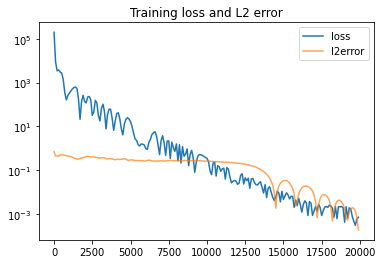

In [9]:
plt.figure()
plt.title("Training loss and L2 error")
plt.semilogy(net.history_interval*np.arange(0,int(len(net.loss_history))).reshape(-1,1),net.loss_history,label = "loss")
plt.semilogy(net.history_interval*np.arange(0,int(len(net.l2error_history))).reshape(-1,1),net.l2error_history,label = 'l2error',alpha=0.7)
plt.legend()
plt.show()

Relative L2-error norm: 0.0006383550767493106


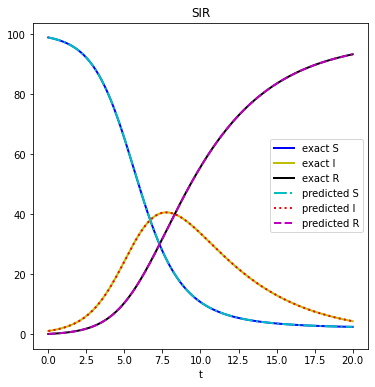

In [10]:
# Make prediction using learned network
U_pred = net.predict(X_test)
err = torch.abs(U_pred-U_test)
err = torch.linalg.norm(err)/torch.linalg.norm(U_test)
print("Relative L2-error norm: {}".format(err))

with torch.no_grad():
    plt.figure(figsize=(6,6))
    plt.title("SIR")
    plt.plot(X_test.cpu(),U_test.cpu()[:,0:1],'b', lw=2, label='exact S')
    plt.plot(X_test.cpu(),U_test.cpu()[:,1:2],'y', lw=2, label='exact I')
    plt.plot(X_test.cpu(),U_test.cpu()[:,2:3],'k', lw=2, label='exact R')
    plt.plot(X_test.cpu(),U_pred.cpu()[:,0:1],'c-.', lw=2, label='predicted S')
    plt.plot(X_test.cpu(),U_pred.cpu()[:,1:2],'r:', lw=2, label='predicted I')
    plt.plot(X_test.cpu(),U_pred.cpu()[:,2:3],'m--', lw=2, label='predicted R')
    plt.legend()
    plt.xlabel('t')
    plt.show()